<a href="https://colab.research.google.com/github/samuel23taku/NoteBooks/blob/main/DiffusionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

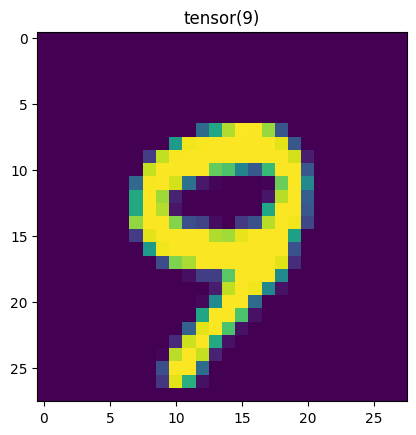

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from torchvision.transforms import  ToTensor, Normalize
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

# Other code
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

testing_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

train_dataloader = DataLoader(
    training_data, batch_size = 1000,shuffle=True
)
test_dataloader = DataLoader(
    testing_data, batch_size = 1000,shuffle=True
)


train_features,train_labels = next(iter(train_dataloader))
eg_image = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(eg_image)
plt.title(label)
plt.show()

In [18]:
## Diffusion Process

In [ ]:
class Util_DoubleConv(nn.Module):
  def __init__(self,in_channels,out_channels,mid_channels=None): # mid_channels for number of neurons in the middle layer
    super().__init__()
    if not mid_channels:
        mid_channels = out_channels
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self,x):
    return self.double_conv(x)

class Util_DownScale(nn.Module):
  def __init__(self,in_channels,out_channels):
    super().__init__()
    self.maxpool_conv = nn.Sequential(
        nn.MaxPool2d(kernel_size=2),
        Util_DoubleConv(in_channels,out_channels)
    )

  def forward(self,x):
    return self.maxpool_conv(x)

class Util_UpScale(nn.Module):
  def __init__(self,in_channels,out_channels,bilinear=True): # Either use bilinear or transposed Conv2d
    super().__init__()
    if bilinear:
      self.up = nn.Upsample(scale_factor=2,mode="bilinear",align_corners=True)
      self.conv = Util_DoubleConv(in_channels=in_channels,out_channels=out_channels,mid_channels= in_channels // 2)
    else:
      self.up = nn.ConvTranspose2d(in_channels=in_channels,out_channels=out_channels,kernel_size = 2,stride=2)
      self.conv = Util_DoubleConv(in_channels,out_channels,mid_channels= in_channels // 2)

  def forward(self,x1,x2):
    '''
        x2 is a skip connection value from the encoder,
        while x1 is the decoder current state
    '''

    x1 = self.up(x1)

    # Compute height difference between x1 and x2
    diffY = x2.size()[2] - x1.size()[2]
    diffX = x2.size()[3] - x1.size()[3]

    # Make x1 match the size of x2
    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,diffY // 2, diffY - diffY // 2])

    # Do skip connection by concaticating tensor from different layers
    x = torch.cat([x2,x1],dim=1)

    return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class DiffusionUNet(nn.Module):
    def __init__(self, in_channels, n_classes, bilinear=False):
        super(DiffusionUNet, self).__init__()
        self.n_channels = in_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (Util_DoubleConv(in_channels, 64))
        self.down1 = (Util_DownScale(64, 128))
        self.down2 = (Util_DownScale(128, 256))
        self.down3 = (Util_DownScale(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Util_DownScale(512, 1024 // factor))
        self.up1 = (Util_UpScale(1024, 512 // factor, bilinear))
        self.up2 = (Util_UpScale(512, 256 // factor, bilinear))
        self.up3 = (Util_UpScale(256, 128 // factor, bilinear))
        self.up4 = (Util_UpScale(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
      x1 = self.inc(x)
      x2 = self.down1(x1)
      x3 = self.down2(x2)
      x4 = self.down3(x3)
      x5 = self.down4(x4)
      x = self.up1(x5, x4)
      x = self.up2(x, x3)
      x = self.up3(x, x2)
      x = self.up4(x, x1)
      logits = self.outc(x)
      return logits

    def use_checkpointing(self):
      self.inc = torch.utils.checkpoint(self.inc)
      self.down1 = torch.utils.checkpoint(self.down1)
      self.down2 = torch.utils.checkpoint(self.down2)
      self.down3 = torch.utils.checkpoint(self.down3)
      self.down4 = torch.utils.checkpoint(self.down4)
      self.up1 = torch.utils.checkpoint(self.up1)
      self.up2 = torch.utils.checkpoint(self.up2)
      self.up3 = torch.utils.checkpoint(self.up3)
      self.up4 = torch.utils.checkpoint(self.up4)
      self.outc = torch.utils.checkpoint(self.outc)
# The noising part
def forward_diffusion(alphas_cumprod, x_start, t, noise):
    batch_size, _, height, width = x_start.size()
    # Expand alphas_cumprod[t] to match the shape of x_start and noise
    alphas_cumprod_t = alphas_cumprod[t].view(batch_size, 1, 1, 1).expand(batch_size, 1, height, width).to(x_start.device)
    return torch.sqrt(alphas_cumprod_t) * x_start + torch.sqrt(1 - alphas_cumprod_t) * noise


## Training Loop

In [ ]:
def get_alphas_cumprod(T):
    betas = np.linspace(1e-4, 0.02, T)
    alphas = 1 - betas
    alphas_cumprod = np.cumprod(alphas)
    return alphas_cumprod

def train_model(train_loader,epoch_counts=30,lr=1e-3,weights_save_path = "./weights"):
  T = 1000  # Number of diffusion steps
  alphas_cumprod = get_alphas_cumprod(T)
  alphas_cumprod = torch.tensor(alphas_cumprod).float()

  model = DiffusionUNet(in_channels=1,n_classes=1,bilinear=False)

  optimizer = optim.Adam(model.parameters(), lr=lr)
  loss_criterion = nn.MSELoss()
# Generate alpha values to noise on each timestep
  model.train()
  for epoch in range(epoch_counts):
    epoch_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
      data = data.view(-1,1,28,28) # Reshape and
      t = torch.randint(0,T,(data.size(0),),dtype=torch.long)
      noise = torch.randn_like(data)
      x_t = forward_diffusion(alphas_cumprod,data,t,noise)

      optimizer.zero_grad()
      predicted_noise = model(x_t)
      print(f"Predicted size {predicted_noise.size()}")
      print(f"Original image size {data.size()}")
      loss = loss_criterion(predicted_noise, noise)
      loss.backward()
      # Update model weights
      optimizer.step()

      epoch_loss += loss.item()

  print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader.dataset):.4f}')

  # Save weights
  torch.save(model.state_dict(),weights_save_path)

train_model(train_dataloader)

X before up1 torch.Size([1000, 1, 28, 28])
Predicted size torch.Size([1000, 1, 28, 28])
Original image size torch.Size([1000, 1, 28, 28])


In [ ]:
# Loading Model Weights
def load_model(model, load_path='model_weights.pth'):
    model.load_state_dict(torch.load(load_path))
    model.eval()
    print(f'Model weights loaded from {load_path}')

# Load the model weights
load_model(model)

# Sampling New Images
def sample(model, num_samples=64):
    model.eval()
    with torch.no_grad():
        x = torch.randn(num_samples, 1, 28, 28)  # Start with random noise
        for t in reversed(range(T)):
            predicted_noise = model(x)
            x = (x - predicted_noise) / np.sqrt(get_alphas_cumprod()[t])
    return x.cpu()

# Generate new images
generated_images = sample(model)

# Plot the generated images
plt.figure(figsize=(8, 8))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()